In [91]:
using Pkg
Pkg.activate("deconvolution"; shared=true)

"/Users/imolk/Library/Julia/environments/deconvolution/Project.toml"

In [92]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [93]:
using HypothesisTests
using Distributions
import StatsBase

In [94]:
using Revise
import DeconvolveDistribution
import DeconvolutionTests

In [95]:
function plot_pdf(d::DeconvolveDistribution.ExpoSpline; kwargs...)
    p = pdf(d)
    θ = d.domain
    Δ = median(diff(θ))
    plt.bar(θ, p./Δ, Δ; kwargs...)
end

plot_pdf (generic function with 1 method)

In [96]:
module KS
    using Distributions
    using DeconvolveDistribution
    using DeconvolveDistribution: DeconvolutionMethod
    using DeconvolutionTests
    include("../src/simulate.jl")

    function sim_deconv(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y, t::Function, method::DeconvolutionMethod; kwargs...)
        data = sim_data(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y)
        deconv_boot_test(data[:Xtilde], data[:Ytilde], data[:σ_X], data[:σ_Y], t, method; kwargs...)
    end
end

Main.KS

In [97]:
# using a module as a cheap way to encapsulate variables
import Random
Random.seed!(1)
sim_hetero = let 
    local F_X = MixtureModel([Normal(-2, 1), Normal(2, 1)], [0.4, 0.6])
    local F_Y = Normal(0, 2)
    local n_X = 200
    local n_Y = 120
    local σ_X_distr = Gamma(2.0, 1.0)
    local σ_Y_distr = Gamma(2.0, 2.0)
    KS.sim_data(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y)
end
;

In [165]:
efron = DeconvolveDistribution.EfronDeconv(6, range(-6.0, stop=6.0, length=32), 1.0);

In [166]:
@time d = DeconvolveDistribution.decon(
        efron, 
        cat(sim_hetero[:Xtilde], sim_hetero[:Ytilde]; dims=1),
        Normal.(0.0, cat(sim_hetero[:σ_X], sim_hetero[:σ_Y]; dims=1)),
        )
;

  0.040874 seconds (10.27 k allocations: 40.417 MiB, 27.10% gc time)


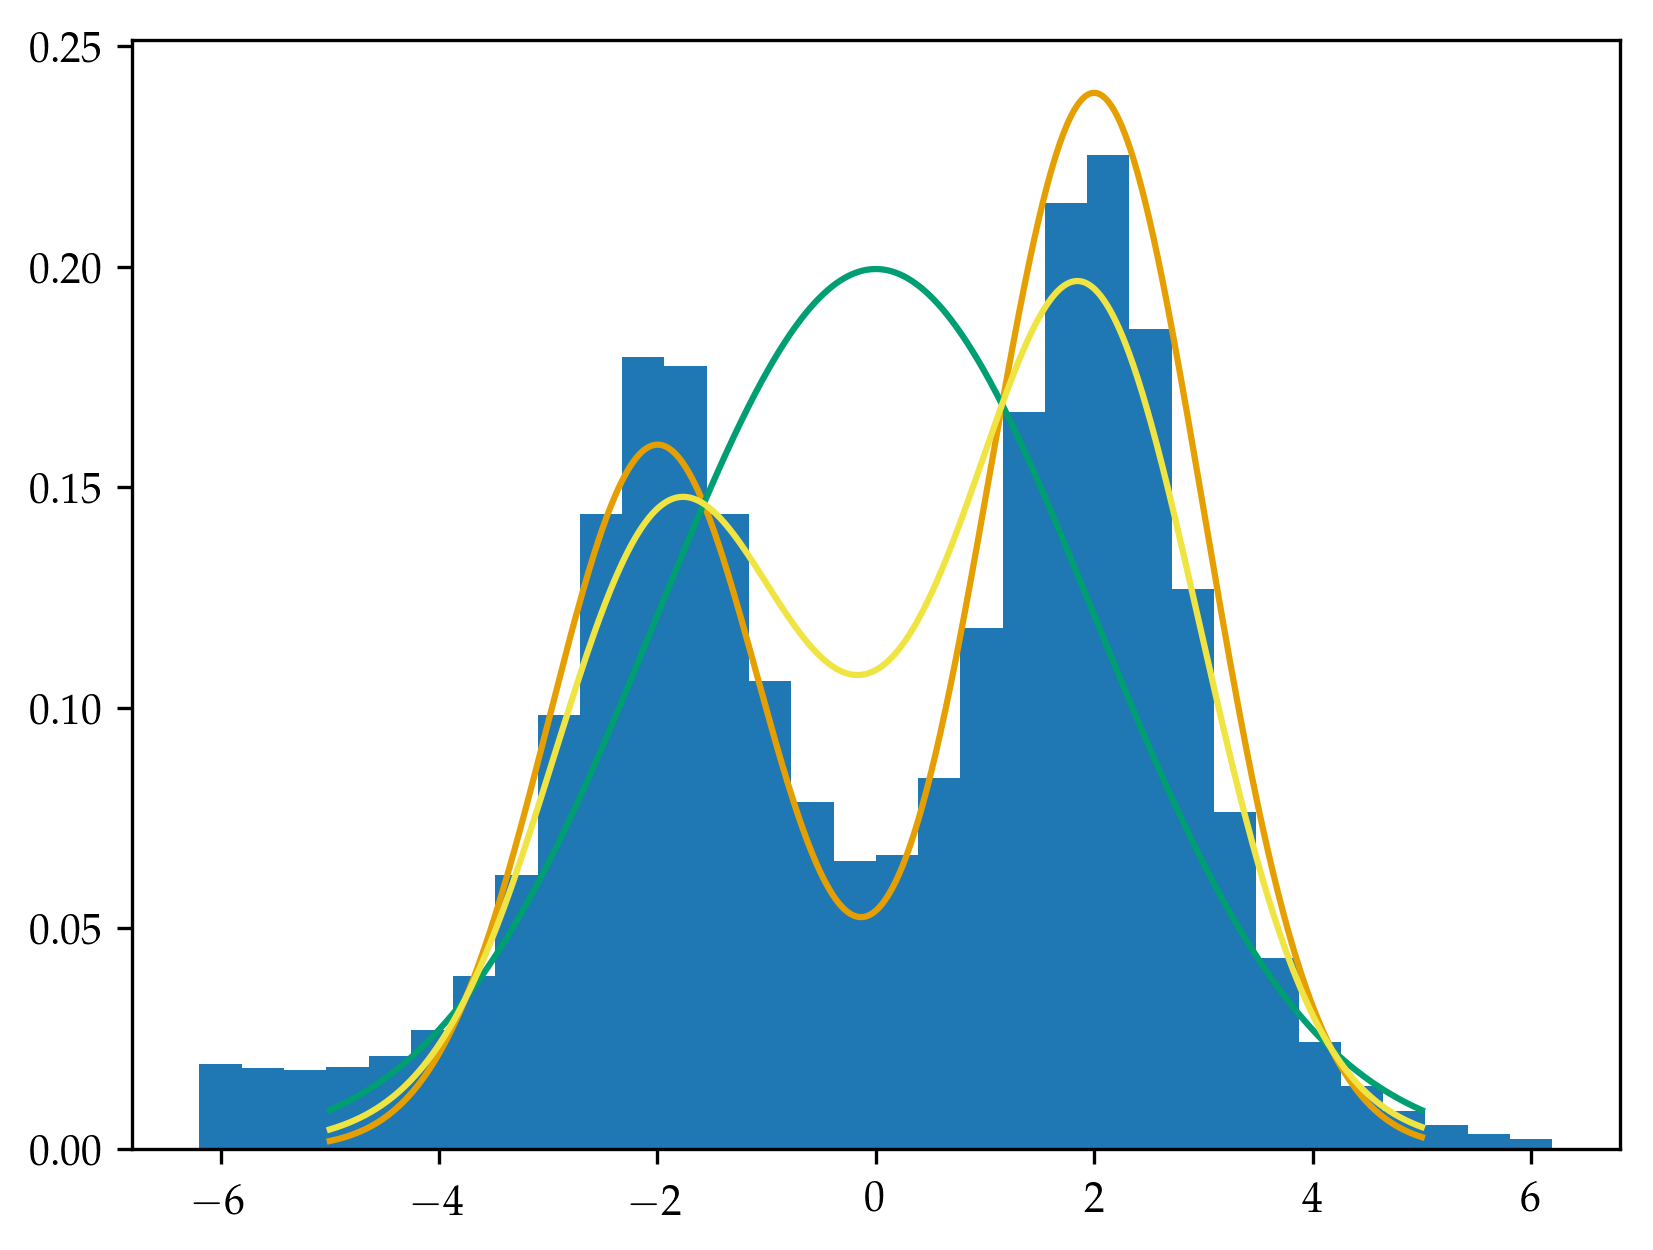

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x16af52b00>

In [167]:
plot_pdf(d)
xx = -5:0.01:5
plt.plot(xx, pdf.(sim_hetero[:F_X], xx), color=cbbPalette[1])
plt.plot(xx, pdf.(sim_hetero[:F_Y], xx), color=cbbPalette[3])
plt.plot(xx, 
    (   sim_hetero[:n_X].*pdf.(sim_hetero[:F_X], xx)
     .+ sim_hetero[:n_Y].*pdf.(sim_hetero[:F_Y], xx)
    ) / (sim_hetero[:n_X] + sim_hetero[:n_Y])
    , 
    color=cbbPalette[4])

In [168]:
DeconvolutionTests.deconv_boot_test(
    sim_hetero[:Xtilde],
    sim_hetero[:Ytilde],
    sim_hetero[:σ_X],
    sim_hetero[:σ_Y],
    DeconvolutionTests.KS_test_statistic,
    efron;
    niter=100
)
@time DeconvolutionTests.deconv_boot_test(
    sim_hetero[:Xtilde],
    sim_hetero[:Ytilde],
    sim_hetero[:σ_X],
    sim_hetero[:σ_Y],
    DeconvolutionTests.KS_test_statistic,
    efron;
    niter=100
)

  0.040755 seconds (17.79 k allocations: 46.136 MiB, 23.36% gc time)


0.63

In [169]:
n_X, n_Y = 200, 100

(200, 100)

In [170]:
KS.sim_deconv(
    Normal(0.0, 2.0), Normal(0.0, 2.0),
    Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
    n_X, n_Y, KS.KS_test_statistic,
    efron
    ; 
    niter=200
    ) 

0.515

# Distribution of p-values

## under the null: KS statistic

In [104]:
@time null_pvals_KS = [
    KS.sim_deconv(
        Normal(0.0, 2.0), Normal(0.0, 2.0),
        Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
        n_X, n_Y, KS.KS_test_statistic,
        efron
        ; 
        niter=200
        ) 
    for _ in 1:400]
;

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196


 25.109179 seconds (10.43 M allocations: 22.639 GiB, 16.65% gc time)


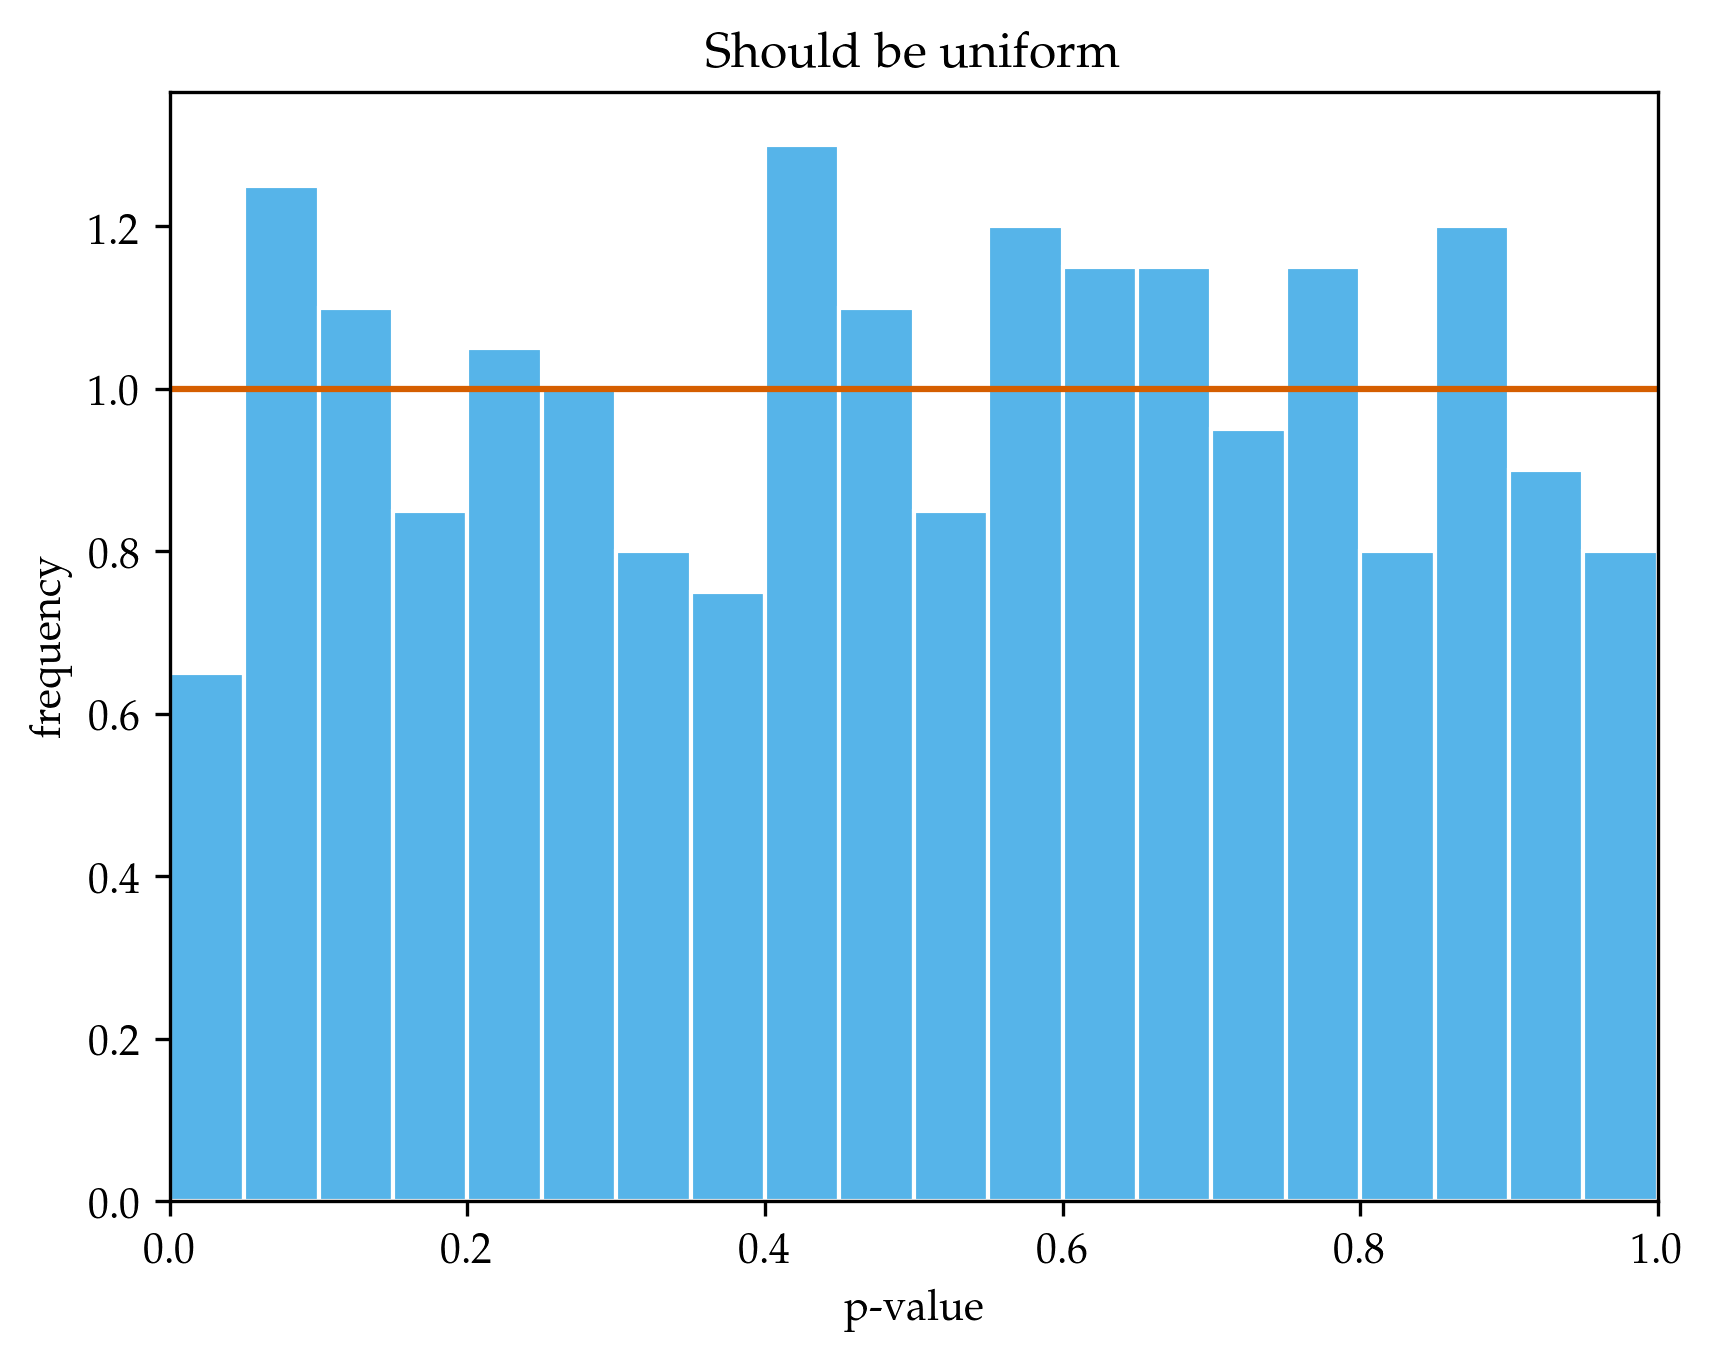

In [106]:
plt.plt[:hist](null_pvals_KS, bins=0:0.05:1.0, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[6])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Should be uniform")
plt.xlim(0, 1)
;

## Under the alternative: KS

In [107]:
@time alt_pvals_KS = [
    KS.sim_deconv(
        Normal(0.0, 2.0), Normal(1.0, 2.0),
        Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
        n_X, n_Y, KS.KS_test_statistic,
        efron
        ; 
        niter=400
        ) 
    for _ in 1:400]
;

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47


 31.222080 seconds (16.18 M allocations: 26.383 GiB, 16.39% gc time)


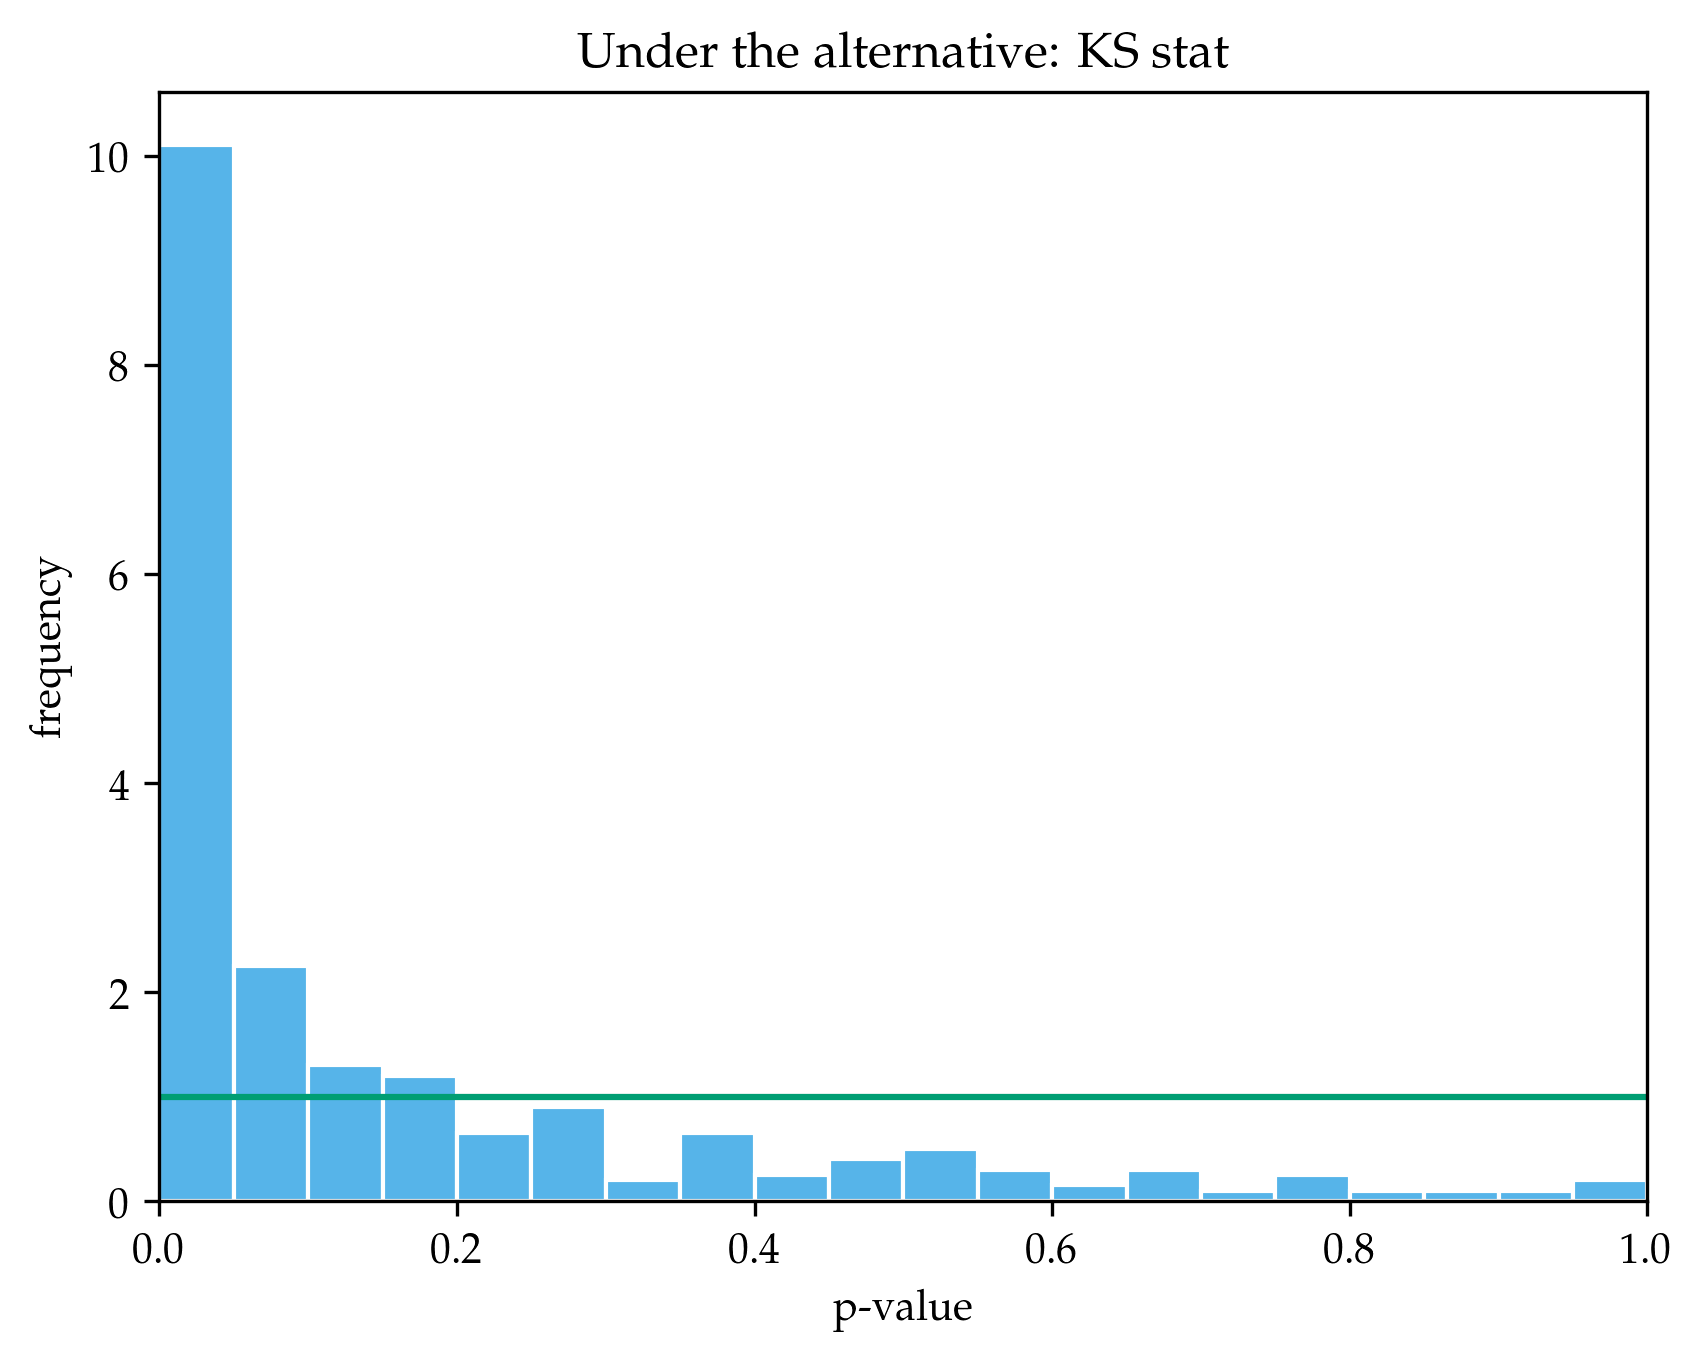

In [110]:
plt.plt[:hist](alt_pvals_KS, bins=0:0.05:1.0, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[3])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Under the alternative: KS stat")
plt.xlim(0, 1)
;

## under the null: deconvolved KS

In [113]:
@time null_pvals_KSdecon = let
    n_X = 100
    n_Y = 150
    p = Inf
    efron_sub = DeconvolveDistribution.EfronDeconv(5, range(-6.0, stop=6.0, length=32), 1.0);
    xgrid = collect(linspace(-10.0, 10.0, 1000))
    t_Lp = KS.distance_test_statistic(p, efron_sub, xgrid)
    pvals = [
        KS.sim_deconv( # perform a single simulation
            Normal(0.0, 2.0), Normal(0.0, 2.0),
            Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
            n_X, n_Y, t_Lp,
            efron
            ; 
            niter=100 # number of *bootstrap* samples
            ) 
        for _ in 1:200]
    pvals
end
;

┌ Warning: Deprecated syntax `implicit assignment to global variable `n_X``.
│ Use `global n_X` instead.
└ @ nothing none:0
┌ Warning: Deprecated syntax `implicit assignment to global variable `n_Y``.
│ Use `global n_Y` instead.
└ @ nothing none:0
┌ Warning: `linspace(start, stop, length::Integer)` is deprecated, use `range(start, stop=stop, length=length)` instead.
│   caller = top-level scope at In[113]:6
└ @ Core In[113]:6
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fa

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 6.141182226405609e-17 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum it

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 5.128086351469641e-15 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum it

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge,

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 1.7294312826260082e-16 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum i

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 2.157216091736292e-13 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warnin

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 1.006059902761486e-16 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warnin

┌ Warning: Linesearch failed, using alpha = 3.710119831592067e-17 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch f

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge,

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge,

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 2.7963095850307705e-13 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum i

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 3.964607330376559e-15 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warnin

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge,

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge,

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 5.93460224000653e-14 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch fa

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 7.377151932381444e-15 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warnin

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 8.574423300464014e-14 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warnin

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge,

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospl

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge,

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 6.455207004490484e-16 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warnin

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 2.361147500955229e-16 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilit

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospl

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 3.9264484919190375e-15 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warni

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

In [115]:
function plot_pvals(pvals)
    bins = 0:0.05:1.0
    # weights add up to one
    # (don't integrate to one)
    weights = fill(1/length(pvals), length(pvals))
    plt.plt[:hist](pvals, 
        bins=bins, 
        weights=weights,
        color=cbbPalette[2], 
        edgecolor="white")
    plt.axhline(1/length(bins), color=cbbPalette[6])
    plt.xlabel("p-value")
    plt.ylabel("frequency")
    plt.xlim(0, 1)
end

plot_pvals (generic function with 1 method)

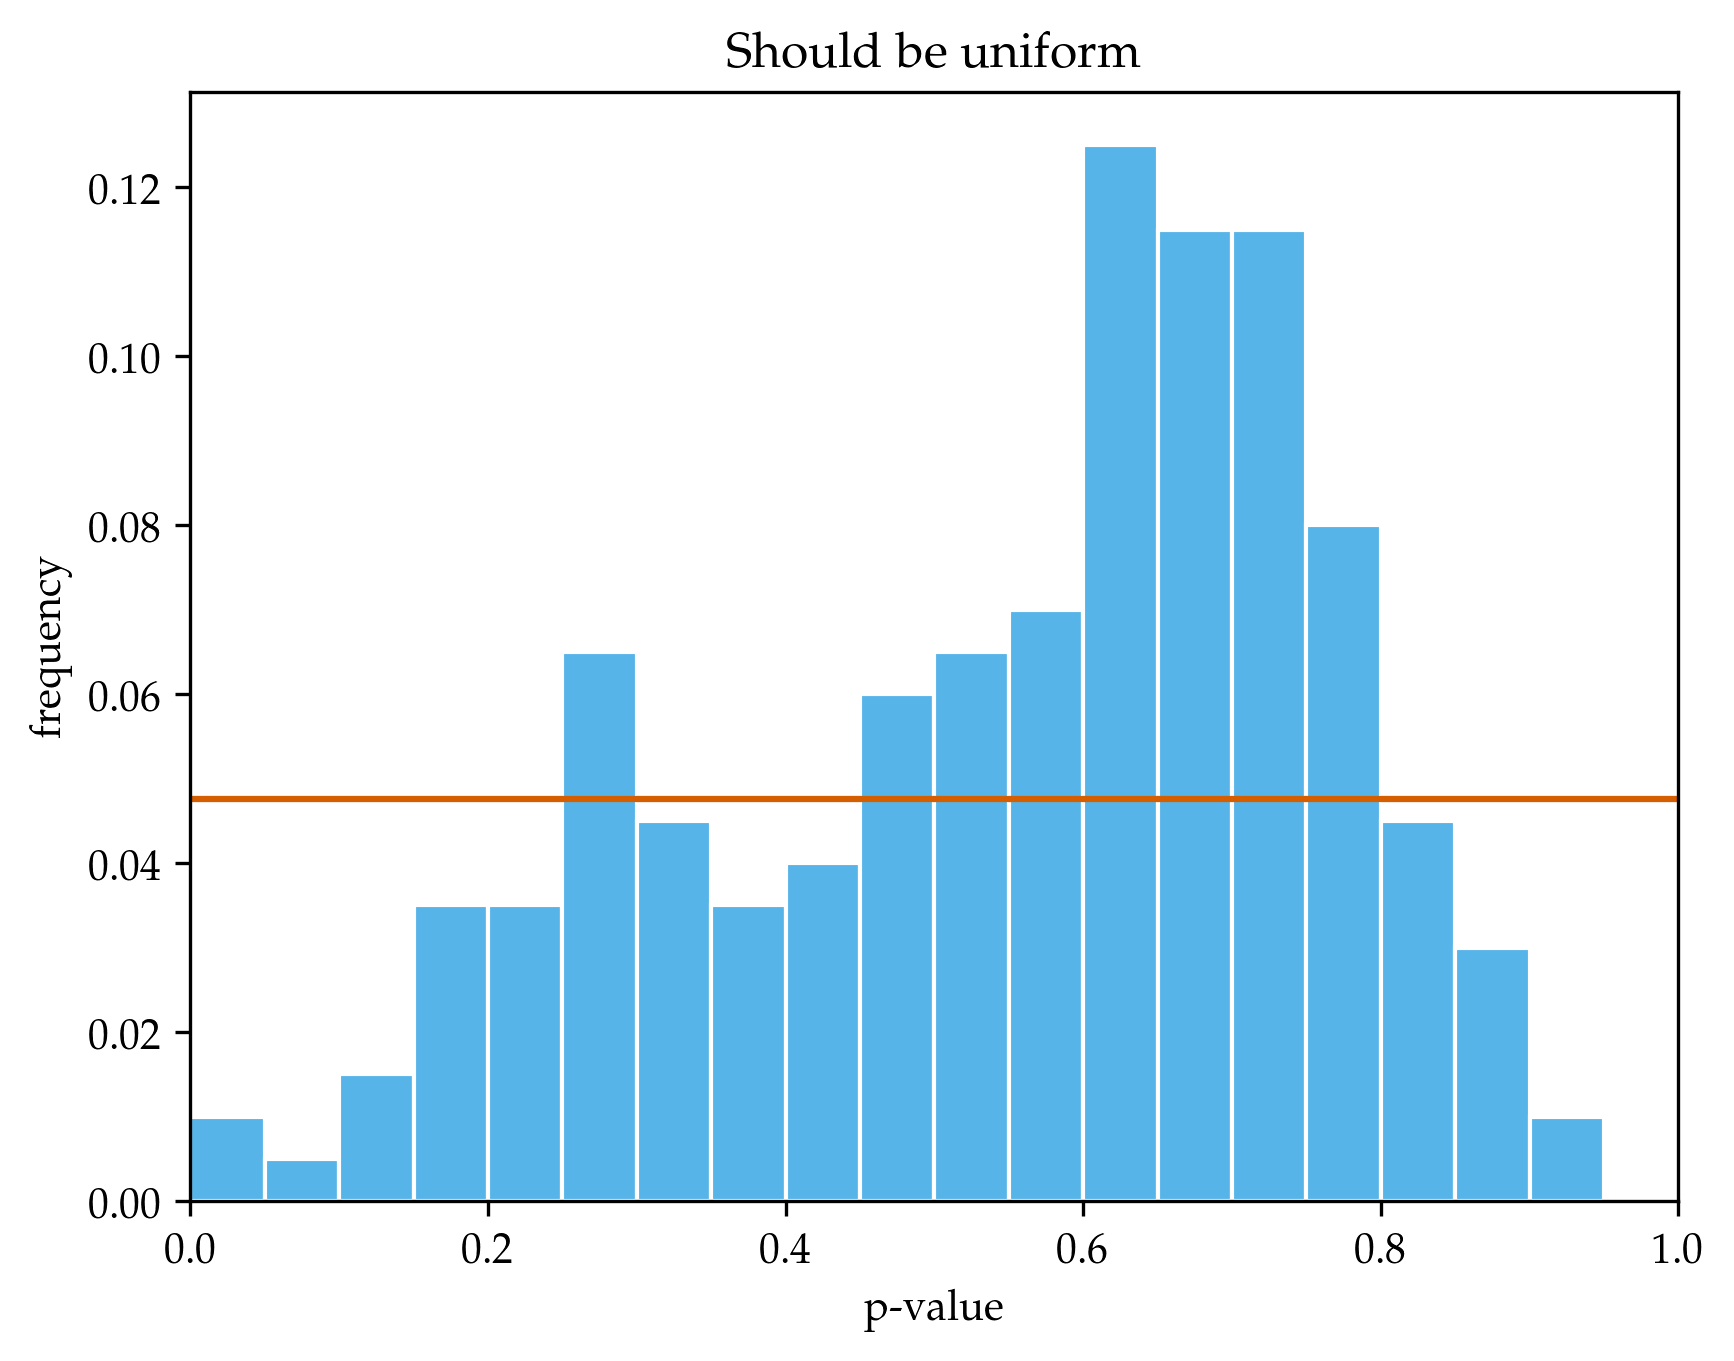

In [120]:
plot_pvals(null_pvals_KSdecon)
plt.title("Should be uniform")
;

## under the alternative: deconvolved KS

In [117]:
n_X, n_Y = 200, 100

(200, 100)

In [118]:
@time alt_pvals_KSdecon = let
    p = Inf
    efron_sub = DeconvolveDistribution.EfronDeconv(5, range(-6.0, stop=6.0, length=32), 1.0);
    xgrid = collect(linspace(-10.0, 10.0, 1000))
    t_Lp = KS.distance_test_statistic(p, efron_sub, xgrid)
    pvals = [
        KS.sim_deconv( # perform a single simulation
            Normal(0.0, 2.0), Normal(1.0, 2.0),
            Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
            n_X, n_Y, t_Lp,
            efron
            ; 
            niter=100 # number of *bootstrap* samples
            ) 
        for _ in 1:200]
    pvals
end
;

┌ Warning: `linspace(start, stop, length::Integer)` is deprecated, use `range(start, stop=stop, length=length)` instead.
│   caller = top-level scope at In[118]:4
└ @ Core In[118]:4
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 7.640507282743866e-15 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warnin

┌ Warning: Linesearch failed, using alpha = 2.044087766970422e-15 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warnin

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 3.1740892241895146e-16 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum i

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 2.7481832032556308e-15 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum i

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 2.821040542596523e-15 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warnin

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 1.1720316536379077e-14 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warni

┌ Warning: Linesearch failed, using alpha = 9.23137928948533e-14 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum ite

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 7.074138750988222e-14 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warnin

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: decon failed to

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 9.706791074945583e-15 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum it

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge,

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 2.6104086435592204e-12 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum i

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 5.438226455034789e-17 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch f

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 2.902556651130115e-15 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warnin

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge,

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 1.7165492232936137e-14 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warni

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 2.355574875141912e-14 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum it

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ O

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch fail

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/imolk/Library/Julia/packages/Optim/U0b9c/src/utilities/perform_linesearch.jl:47
┌ Warning: decon failed to converge
└ @ DeconvolveDistribution /Users/imolk/Documents/Harvard/AstroStatistics/DeconvolveDistribution/src/expospline.jl:196
Excessive output truncated after 524539 bytes.

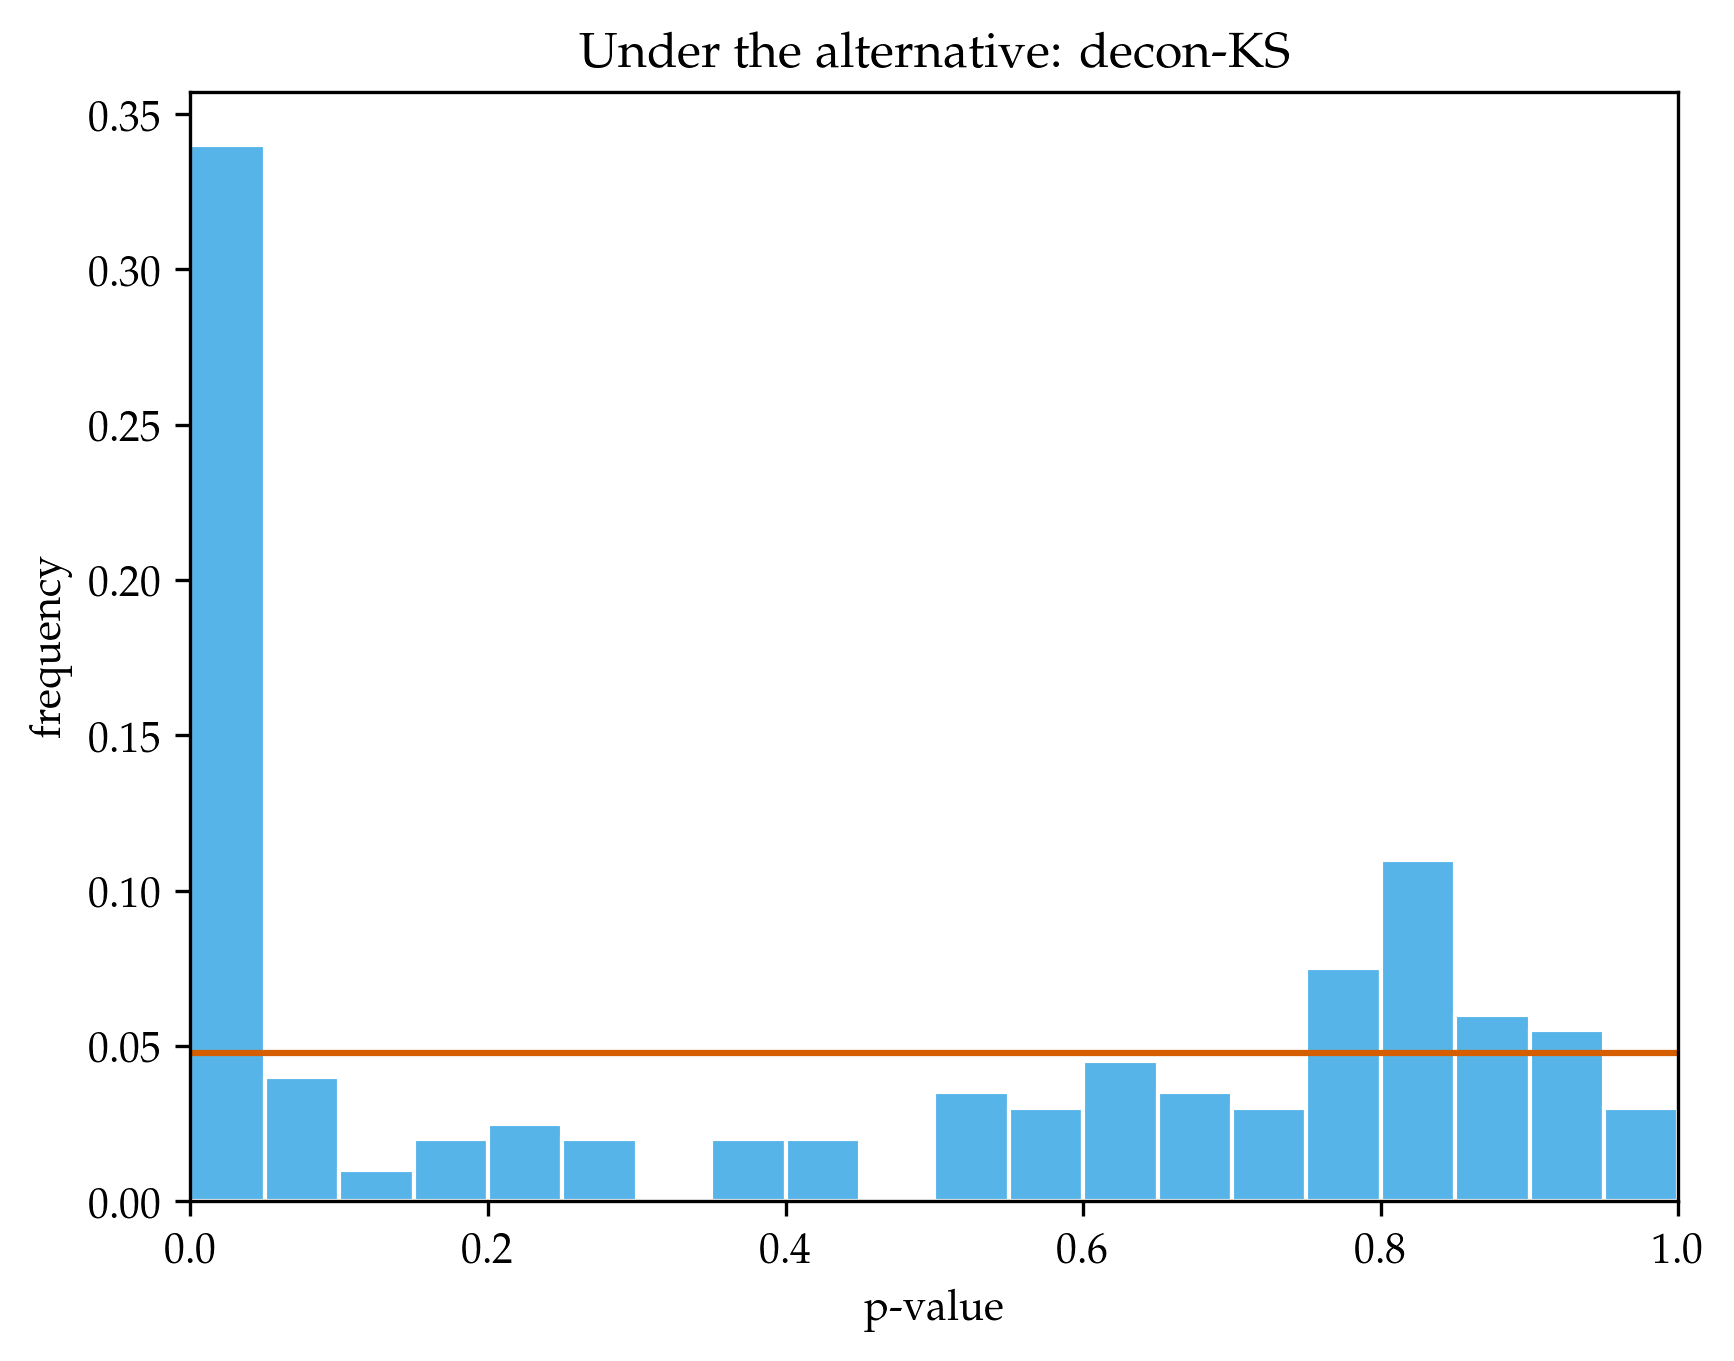

In [119]:
plot_pvals(alt_pvals_KSdecon)
plt.title("Under the alternative: decon-KS")
;